# Exp: use VGG19 to do Style Transform in drawing

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import time
from PIL import Image
import requests
from skimage.io import imread

In [1]:
import torch
import torch.optim as optim
from torchvision import models
from torchvision import transforms

In [3]:
## load the pretrained vgg19
vgg19 = models.vgg19(pretrained=True)
vgg = vgg19.features
for param in vgg.parameters():
    param.requires_grad_(False)

In [26]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
## def load image func
def load_image(img_path,max_size=400,shape=None):
    image = Image.open(img_path).convert('RGB')
    ## control the max size
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    ## turn to the certain shape
    if shape is not None:
        size = shape
    transform = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4,0.4,0.4],std=[0.2,0.2,0.2])
        ]
    )
    image = transform(image)[:3,:,:].unsqueeze(dim=0)
    return image

In [5]:
## def tensor to im convert func 
def im_convert(tensor):
    """
    turn tensor size from [1,c,h,w] to [h,w,c] 
    """
    image = tensor.data.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array([0.2,0.2,0.2]) + np.array([0.4,0.4,0.4])
    image = image.clip(0,1)
    return image

content shape:  torch.Size([1, 3, 400, 574])
style shape:  torch.Size([1, 3, 400, 529])


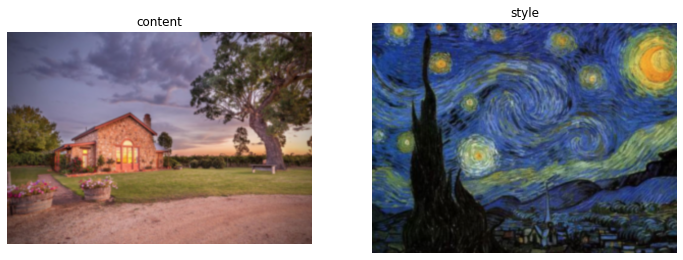

In [6]:
## get content and style and plot them
content = load_image("./data/content.png")
style = load_image("./data/style.png")
print("content shape: ",content.shape)
print("style shape: ",style.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.imshow(im_convert(content))
ax1.set_title("content")
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.set_title("style")
ax2.axis("off")
plt.show()

In [7]:
## def get certain layer's features func
def get_features(image,model,layers=None):
    if layers is None:
        layers = {
            '0':'conv1_1',
            '5':'conv2_1',
            '10':'conv3_1',
            '19':'conv4_1',
            '21':'conv4_2',
            '28':'conv5_1',
        }
    features = {}
    x = image
    for name,layer in model._modules.items(): # get every layer's dict
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [8]:
## def Gram Matrix func
def gram_matrix(tensor):
    b,c,h,w = tensor.size()
    tensor = tensor.view(c,h*w)
    gram = torch.mm(tensor,tensor.t()) # gram = AxA^T
    return gram

In [9]:
## get features on content and style
content_features = get_features(content,vgg)
style_features = get_features(style,vgg)

In [10]:
## get gram matrix on style
style_grams = {}
for layer in style_features:
    gram = gram_matrix(style_features[layer])
    style_grams[layer] = gram

In [17]:
## init
style_weights = {
    'conv1_1':1.,
    'conv2_1':0.75,
    'conv3_1':0.2,
    'conv4_1':0.2,
    'conv5_1':0.2
}
alpha = 1
beta = 1e6
content_weight = alpha
style_weight = beta
target = content.clone().requires_grad_(True)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20 - total loss: 78063632.0


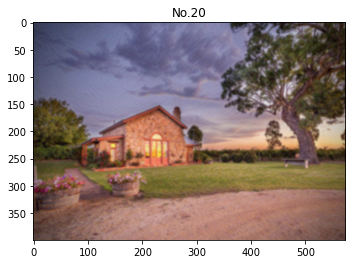

Epoch 40 - total loss: 65513984.0


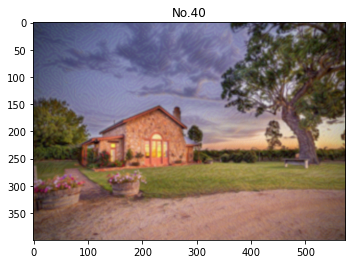

Epoch 60 - total loss: 55101716.0


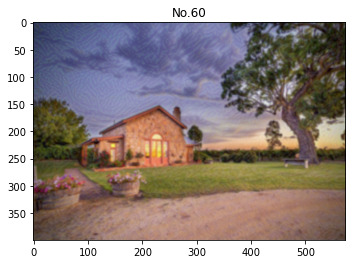

Epoch 80 - total loss: 45903832.0


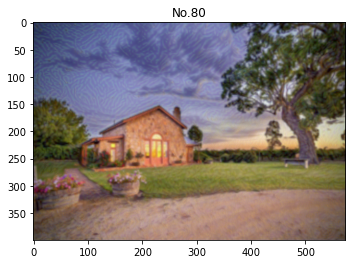

Epoch 100 - total loss: 37728060.0


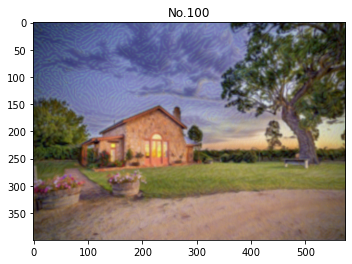

Epoch 120 - total loss: 30669926.0


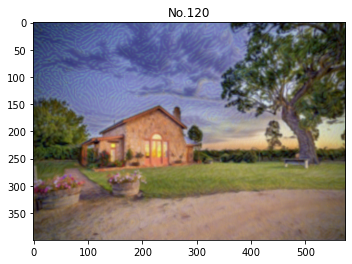

Epoch 140 - total loss: 24795880.0


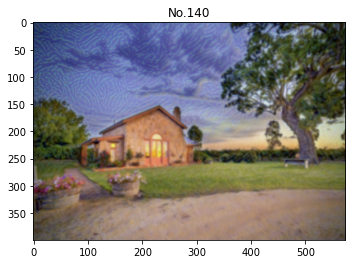

Epoch 160 - total loss: 20076612.0


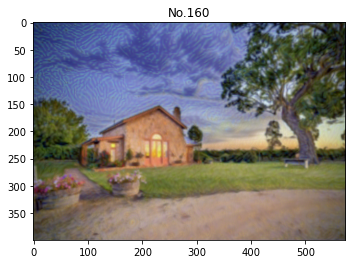

Epoch 180 - total loss: 16391959.0


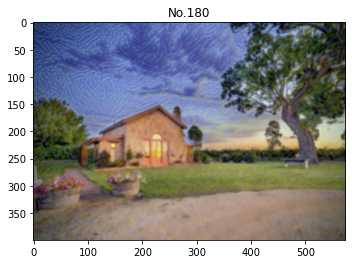

Epoch 200 - total loss: 13592150.0


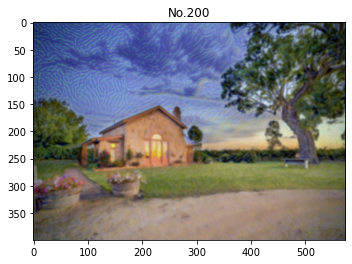

In [18]:
## train
from tqdm.notebook import tqdm

total_loss_all = []
content_loss_all = []
style_loss_all = []
optimizer = optim.Adam([target],lr = 0.003)
steps = 200
show_every = steps//10

for i in tqdm(range(1,steps+1)):
    # content loss
    target_features = get_features(target,vgg)
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    # style loss from chosen layers
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _,c,h,w = target_feature.shape
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram-style_gram)**2)
        style_loss += layer_style_loss / (c*h*w)
    # total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    # log
    content_loss_all.append(content_loss.item())
    style_loss_all.append(style_loss.item())
    total_loss_all.append(total_loss.item())
    # optimize
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # show
    if i % show_every == 0:
        print("Epoch {} - total loss: {}".format(i,total_loss.item()))
        
        im = im_convert(target)
        plt.imshow(im)
        plt.title("No.{}".format(i))
        plt.show()
        
        result = Image.fromarray((im*255).astype(np.uint8))
        result.save("./style_transform_result/No."+str(i)+".png")

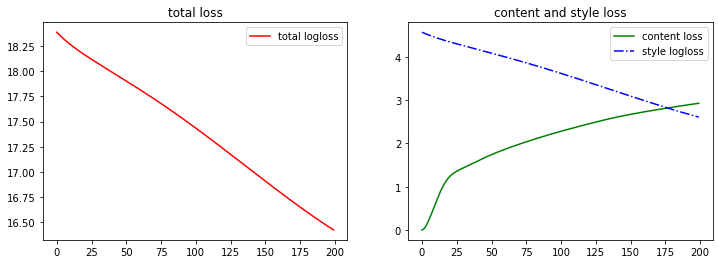

In [23]:
## plot train process
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(np.log(total_loss_all),"r",label="total logloss")
plt.legend()
plt.title("total loss")
plt.subplot(1,2,2)
plt.plot(content_loss_all,"g-",label="content loss")
plt.plot(np.log(style_loss_all),"b-.",label="style logloss")
plt.legend()
plt.title("content and style loss")
plt.show()